# Sorting Fixed Length Lists

### Install and import

In [ ]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-80ot_n5l
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-80ot_n5l
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 0825c5eb4196e7ad72d28bcf4e615306b3897490
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import random
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
import transformer_lens.utils as utils
import circuitsvis as cv
from tqdm.auto import tqdm
from fancy_einsum import einsum

from matplotlib import pyplot as plt
import plotly.io as pio
import plotly.express as px

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install git+https://github.com/neelnanda-io/neel-plotly.git

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-06j3sbk2
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-06j3sbk2
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel-plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10186 sha256=9570825397c6bc4610e145271a0e1fab810d13b683dd9b15baf406e8e14d9c7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ig2tdxc/wheels/32/cf/25/0103b4be02266c40faf008ffa9565a2ba07d1c63118fccc390
Successfully built neel-plotly


# Graphing Config

In [ ]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "colab"
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Variable hyperparameters

In [ ]:
# Input/label length
LIST_LENGTH = 25

# Size of vocabulary
D_VOCAB = 50

# Repetitions?
ALLOW_REPETITIONS = False

# Attention only?
ATTN_ONLY = True

# Positional encoding?
POS_EM = False

# Model dimenions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 64
D_HEAD = 32

D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 128

### Invariable hyperparameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds
TRAIN_SEED = 506
VAL_SEED = 234
TEST_SEED = 39539

#  Max sequence length
N_CTX = 2 * LIST_LENGTH + 2 # start and mid tokens

# Real tokens range from 0 to D_VOCAB - 2
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# Special tokens
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'cuda'


### Data generator and datasets

In [ ]:
# Generate a batch of fixed-length lists
def batch_list_generator(batch_size, allow_repetitions, max_length=LIST_LENGTH):
    batch_data = []

    for _ in range(batch_size):
        if allow_repetitions:
            list_data = torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (max_length,), device=DEVICE)
        else:
            list_data = torch.tensor(random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), max_length), device=DEVICE)

        batch_data.append(list_data)

    return torch.stack(batch_data)

# Data preparation
def prepare_data(batch_size, dataset_type,max_length=LIST_LENGTH):
    dataset_seeds = {'train': TRAIN_SEED, 'val': VAL_SEED, 'test': TEST_SEED}
    torch.manual_seed(dataset_seeds[dataset_type])

    while True:
        raw_batch = batch_list_generator(batch_size, ALLOW_REPETITIONS, max_length)

        start_token = START_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.int64, device=DEVICE)
        mid_token = MID_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.int64, device=DEVICE)

        sorted_batch = torch.sort(raw_batch, dim=1).values
        combined_batch = torch.cat([start_token, raw_batch, mid_token, sorted_batch], dim=1)

        yield combined_batch

# Data Generators
def train_data_generator():
    return prepare_data(DEFAULT_BATCH_SIZE, 'train')

def single_batch_data_generator(dataset_type):
    return next(prepare_data(1000, dataset_type))


# Validation and test data
validation_data = single_batch_data_generator('val')
test_data = single_batch_data_generator('test')

### Loss function

In [ ]:
def loss_fn(logits,tokens,return_per_token=False):
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

### Accuracy and validation

In [ ]:
def compute_accuracy(logits, tokens):
    sorted_start_pos = LIST_LENGTH + 2
    adjusted_logits = logits[:, sorted_start_pos-1:-1]
    predictions = adjusted_logits.argmax(dim=-1)
    relevant_tokens = tokens[:, sorted_start_pos:]
    correct_predictions = (predictions == relevant_tokens).prod(dim=1).float()
    accuracy = correct_predictions.mean().item()
    return accuracy

def validate_model(model, input_data):
    logits = model(input_data)
    acc = compute_accuracy(logits, tokens=input_data)
    return acc

def deactivate_positional_embeddings(model):
    model.pos_embed.W_pos.data[:] = 0.
    model.pos_embed.W_pos.requires_grad = False

## Training

### Model

In [ ]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_mlp = D_MODEL*4,
    d_vocab=D_VOCAB,
    act_fn="relu",
    normalization_type=None,
    default_prepend_bos=False,
    seed=42,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)
# Disable positional encoding
if not POS_EM:
  deactivate_positional_embeddings(model)

### Disable the biases, as we don't need them for this task and it makes things easier to interpret

In [ ]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

### Training setup

In [ ]:
# Number of epochs
n_epochs = 25000

# Optimization
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=1000)

# Training data generator
train_gen = train_data_generator()

train_accuracies = []
val_accuracies = []

def train_model(model):
    #wandb.init(project="Sort_Fixed_List", name="1L1H_NR")

    train_losses = []

    for epoch in range(n_epochs):
        tokens = next(train_gen).to(device=DEVICE)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
       # scheduler.step(loss)

        if epoch % 100 == 0:
            train_losses.append(loss.item())
            train_acc = compute_accuracy(logits, tokens)
            val_acc = validate_model(model, validation_data)
            val_loss = loss_fn(model(validation_data), validation_data)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                f"train_loss= {loss.item()}; val_loss= {val_loss}; "
                f"{train_acc= :.3%}; {val_acc= :.3%}"
            )

   # wandb.finish()
    return (train_losses, train_accuracies, val_accuracies)

### Train or load model

In [ ]:
train_model(model)

Epoch 0/25000 (0%) : train_loss= 3.9268956184387207; val_loss= 3.920631170272827; train_acc= 0.000%; val_acc= 0.000%
Epoch 100/25000 (0%) : train_loss= 2.579984664916992; val_loss= 2.557638645172119; train_acc= 0.000%; val_acc= 0.000%
Epoch 200/25000 (1%) : train_loss= 1.4832507371902466; val_loss= 1.4816677570343018; train_acc= 0.000%; val_acc= 0.000%
Epoch 300/25000 (1%) : train_loss= 1.3818671703338623; val_loss= 1.3935295343399048; train_acc= 0.000%; val_acc= 0.000%
Epoch 400/25000 (2%) : train_loss= 1.3226299285888672; val_loss= 1.3252105712890625; train_acc= 0.000%; val_acc= 0.000%
Epoch 500/25000 (2%) : train_loss= 1.2233136892318726; val_loss= 1.2275416851043701; train_acc= 0.000%; val_acc= 0.000%
Epoch 600/25000 (2%) : train_loss= 1.140916109085083; val_loss= 1.1406701803207397; train_acc= 0.000%; val_acc= 0.000%
Epoch 700/25000 (3%) : train_loss= 1.0387150049209595; val_loss= 1.034983515739441; train_acc= 0.000%; val_acc= 0.000%
Epoch 800/25000 (3%) : train_loss= 0.9773904681

([3.9268956184387207,
  2.579984664916992,
  1.4832507371902466,
  1.3818671703338623,
  1.3226299285888672,
  1.2233136892318726,
  1.140916109085083,
  1.0387150049209595,
  0.977390468120575,
  0.9048276543617249,
  0.8276829123497009,
  0.760699450969696,
  0.6871464252471924,
  0.6448830366134644,
  0.5833860039710999,
  0.5531959533691406,
  0.4912331998348236,
  0.4695435166358948,
  0.44500476121902466,
  0.4102599322795868,
  0.3815484642982483,
  0.31585752964019775,
  0.3083871901035309,
  0.29061099886894226,
  0.2835693061351776,
  0.26406946778297424,
  0.24665942788124084,
  0.2070310115814209,
  0.20044554769992828,
  0.1870308816432953,
  0.16152814030647278,
  0.16724616289138794,
  0.16532202064990997,
  0.16352690756320953,
  0.150424987077713,
  0.1249784454703331,
  0.11042804270982742,
  0.09348321706056595,
  0.08370519429445267,
  0.06933245807886124,
  0.058092791587114334,
  0.0342547781765461,
  0.029840780422091484,
  0.029392361640930176,
  0.0294337365776

In [ ]:
test_acc = validate_model(model, test_data)
print(f"{test_acc=:.3%}\n")

test_acc=99.800%



In [ ]:
from neel_plotly.plot import line
line([train_accuracies, val_accuracies], xaxis="Epoch", yaxis="Accuracy", title="Training and Validation Accuracies",line_labels=['train', 'test'], toggle_x=True, toggle_y=True)

## Analyze the model

### Attention patterns

In [ ]:
# An instance of test_data
test_input = test_data[5, :]
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
preds = logits[:, LIST_LENGTH+1 : -1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, test_input))
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

# Get model's activaions and weights

In [ ]:
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
print(logits.numel())

for param_name, param in cache_model.items():
    print(param_name, param.shape)

2600
hook_embed torch.Size([52, 64])
hook_pos_embed torch.Size([52, 64])
blocks.0.hook_resid_pre torch.Size([52, 64])
blocks.0.attn.hook_q torch.Size([52, 1, 32])
blocks.0.attn.hook_k torch.Size([52, 1, 32])
blocks.0.attn.hook_v torch.Size([52, 1, 32])
blocks.0.attn.hook_attn_scores torch.Size([1, 52, 52])
blocks.0.attn.hook_pattern torch.Size([1, 52, 52])
blocks.0.attn.hook_z torch.Size([52, 1, 32])
blocks.0.hook_attn_out torch.Size([52, 64])
blocks.0.hook_resid_post torch.Size([52, 64])


# Singular Value Decomposition

In [ ]:
W_E = model.embed.W_E[:-1]
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

### Looking at weights

Observations:

- Tokens tend to pay the most attention to their most immediate followers (in their total ordering)
- `START` token's attention seems kind of random.
- `MID` token's attention is inversely proportional to the token's position in the ordering (i.e. number magnitude).


In [ ]:
QK = model.W_E @ model.blocks[0].attn.W_Q[0] @  model.blocks[0].attn.W_K[0].T @model.W_E.T
imshow(QK)

###  Eigenvalue Copying Scores
"The OV Circuit for a head (the factorised matrix) is a linear map that determines what information is moved from the source position to the destination position. Because this is low rank, it can be thought of as reading in some low rank subspace of the source residual stream and writing to some low rank subspace of the destination residual stream (with maybe some processing happening in the middle)."

"One of the most striking things about looking at these matrices is that most attention heads in one layer models dedicate an enormous fraction of their capacity to copying. The OV circuit sets things up so that tokens, if attended to by the head, increase the probability of that token, and to a lesser extent, similar tokens. The QK circuit then only attends back to tokens which could plausibly be the next token. Thus, tokens are copied, but only to places where bigram-ish statistics make them seem plausible."

 [reference](https://transformer-circuits.pub/2021/framework/index.html)

In [ ]:
def get_full_ov_copying_score(model):
  full_OV_circuit = model.embed.W_E @ model.OV @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum().real / full_OV_circuit_eigenvalues.abs().sum()
  return full_OV_copying_score.detach().item()

get_full_ov_copying_score(model)

0.8774996995925903

In [ ]:
OV_circuit_all_heads = model.embed.W_E @ model.OV @ model.unembed.W_U
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues
OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head", zmax=1.0, zmin=-1.0)

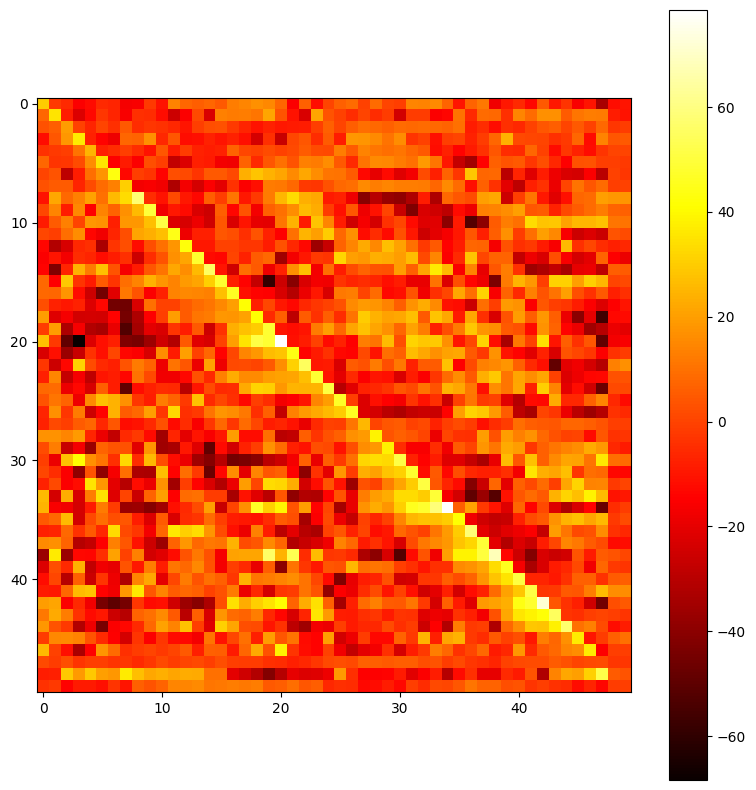

In [ ]:
def plot_ov_heatmap(model, pos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))

  token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

  embeddings_value = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
                          token_embeddings_at_pos, attn.W_V)

  embeddings_out = einsum("n_heads d_vocab d_model, n_heads d_model d_model1 -> n_heads d_vocab d_model1",
                        embeddings_value, attn.W_O)

  ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach().cpu()

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

plot_ov_heatmap(model)

In [ ]:
if not ATTN_ONLY:
  OV = model.W_E @ model.W_V[0, 0] @ model.W_O[0, 0] @ model.W_in[0]
  imshow(OV, yaxis="Input Vocab", xaxis="Neuron")